In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import seaborn as sns
# from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    '../data/loans/LoanStats3d.csv', 
    low_memory=False,
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [89]:
len(y2015.columns)

103

In [91]:
y2015.dtypes

id                                float64
member_id                         float64
loan_amnt                         float64
funded_amnt                       float64
funded_amnt_inv                   float64
term                               object
int_rate                          float64
installment                       float64
grade                              object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
issue_d                            object
loan_status                        object
pymnt_plan                         object
purpose                            object
title                              object
dti                               float64
delinq_2yrs                       float64
inq_last_6mths                    float64
mths_since_last_delinq            float64
mths_since_last_record            float64
open_acc                          

In [4]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
#     print(i)
#     print(column.nunique())

In [5]:
# Convert ID and Interest Rate to numeric.
# y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [6]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [8]:
sample = y2015.sample(frac=.75)
resize = sample.drop('loan_status', 1)
resize = pd.get_dummies(resize)
resize = resize.dropna(axis=1)

In [48]:
# change scientific notation for NP
np.set_printoptions(suppress=False)

In [49]:
# # Sample code for converting features to reduced components
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(resize)
principalDf = pd.DataFrame(data = principalComponents)

Multiple Correspondence Analysis: Qualitative or Mixed<br>
PCA: Quantitative 

In [101]:
print(pca.explained_variance_ratio_.cumsum())

[0.99862012 0.9996461  0.99994334 0.99996637 0.99998171 0.99999155
 0.99999524 0.99999683 0.99999796 0.99999865 0.99999924 0.99999958
 0.99999986 0.99999993 0.99999996 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


In [98]:
print(pca.explained_variance_.cumsum())

[1.92338677e+14 1.97607473e+11 5.72492314e+10 4.43570649e+09
 2.95426995e+09 1.89515925e+09 7.12313479e+08 3.05725459e+08
 2.18144355e+08 1.31853234e+08 1.14717460e+08 6.38125362e+07
 5.45959081e+07 1.34513198e+07 6.00712181e+06 5.38409954e+06
 1.57750199e+06 6.07668533e+05 1.84648386e+05 8.14142238e+03
 4.73964575e+03 7.86598510e+02 3.74024205e+02 3.11494711e+02
 2.44415474e+02 1.28457314e+02 7.18625933e+01 6.67110392e+01
 4.52731945e+01 4.18962257e+01]


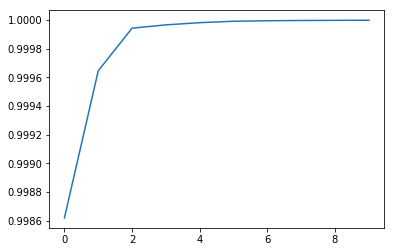

In [103]:
scale = list(pca.explained_variance_ratio_.cumsum())

plt.plot(range(len(scale[0:10])),scale[0:10])
plt.show()

In [104]:
dir(pca)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_fit',
 '_fit_full',
 '_fit_truncated',
 '_get_param_names',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'mean_',
 'n_components',
 'n_components_',
 'n_features_',
 'n_samples_',
 'noise_variance_',
 'random_state',
 'score',
 'score_samples',
 'set_params',
 'singular_values_',
 'svd_solver',
 'tol',
 'transform',
 'whiten

In [146]:
pca.components_[0]

array([-0.68307011, -0.73035273,  0.00000586,  0.00000586,  0.00000603,
        0.00000002,  0.00000025, -0.00007416, -0.00000001, -0.        ,
       -0.        , -0.        , -0.        , -0.00000873,  0.00000001,
       -0.00009828, -0.00009816,  0.0001108 ,  0.00011086,  0.00008663,
        0.00002203,  0.00000001,  0.00000213,  0.00000038,  0.00002779,
       -0.        , -0.        ,  0.        , -0.00000027, -0.00012107,
       -0.00005443, -0.        , -0.00000752, -0.        , -0.00000008,
       -0.00000002, -0.00000001,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.00000001, -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.00000001, -0.        ,  0.        , -0.00019278,
       -0.00005113, -0.00002922, -0.00006843, -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.  

In [150]:
inputs = resize.iloc[0]

pandas.core.series.Series

In [143]:
loadings = pca.transform(inputs)

1

In [152]:
np.dot(inputs,pca.components_[0]*np.sqrt(pca.explained_variance_[0]))

-1136941972774951.5

In [87]:
principalDf = principalDf[principalDf.columns[0:2]]

In [88]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = principalDf
Y = sample['loan_status']
# X = pd.get_dummies(X)
# X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.60944722, 0.60870666, 0.60576223, 0.60701621, 0.60447076,
       0.60711798, 0.60470566, 0.60913898, 0.60609899, 0.60315399])

In [13]:
Y.head()

203374    Late (16-30 days)
358617          Charged Off
340673              Current
31875            Fully Paid
403884              Current
Name: loan_status, dtype: object

In [14]:
len(Y)

315821

In [15]:
X.head()

,0,1,2,3,4,5,6,7,8,9
0,-3.073995e+06,106554.212238,177454.784754,6180.953742,-87248.973341,-2139.962769,-2213.083579,-15259.199218,15322.825150,-13561.468598
1,1.711190e+07,-71104.333101,-194926.656633,-30246.548868,1582.670091,-15439.406291,3236.202836,4194.598020,3102.072590,2075.602287
2,1.479500e+07,-35778.128654,-101803.617313,66613.056974,-7141.685845,22448.800256,1683.180169,-8569.811576,1882.123399,-2552.111040
3,-1.748477e+07,-98866.194924,19949.793924,185.915525,-41165.382451,35649.141644,30012.211359,-3001.563204,-17846.642842,15682.896200
4,2.232815e+07,-123165.583779,-129558.983681,27522.289056,3181.761845,39972.316356,-16674.619123,-11202.367055,17450.858295,-13373.050466


In [16]:
X.describe()

,0,1,2,3,4,5,6,7,8,9
count,3.158210e+05,3.158210e+05,3.158210e+05,3.158210e+05,3.158210e+05,3.158210e+05,3.158210e+05,3.158210e+05,3.158210e+05,3.158210e+05
mean,-3.405972e-10,-1.305614e-09,4.703578e-11,-4.050416e-11,-3.375681e-12,1.477440e-11,1.107679e-11,-1.258337e-12,-8.152309e-13,4.576735e-12
std,1.386862e+07,4.445306e+05,2.392681e+05,6.660110e+04,5.435320e+04,4.353343e+04,2.668920e+04,1.748501e+04,1.476971e+04,1.148274e+04
min,-2.166036e+07,-8.644124e+05,-3.324468e+05,-1.145414e+06,-1.940939e+06,-9.839886e+05,-8.708528e+05,-1.088885e+05,-2.279475e+05,-4.363941e+05
25%,-1.159445e+07,-8.343337e+04,-1.672282e+05,-2.610348e+04,-1.698077e+04,-1.932253e+04,-8.394694e+03,-9.095584e+03,-6.984576e+03,-6.017023e+03
50%,-1.961437e+06,9.775402e+03,-8.289972e+04,-7.155552e+03,8.031243e+03,-4.981472e+03,-1.572052e+03,2.073468e+03,-4.370615e+02,-1.503376e+03
75%,1.142811e+07,7.288165e+04,1.023918e+05,1.695443e+04,2.639958e+04,1.303401e+04,7.291153e+03,1.043763e+04,7.362043e+03,2.166283e+03
max,7.868442e+07,4.930607e+07,1.128349e+07,8.306405e+06,2.601065e+06,9.116316e+06,5.888669e+06,2.622447e+06,1.504788e+06,1.186152e+06


In [17]:
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315821 entries, 0 to 315820
Data columns (total 10 columns):
0    315821 non-null float64
1    315821 non-null float64
2    315821 non-null float64
3    315821 non-null float64
4    315821 non-null float64
5    315821 non-null float64
6    315821 non-null float64
7    315821 non-null float64
8    315821 non-null float64
9    315821 non-null float64
dtypes: float64(10)
memory usage: 24.1 MB
